# Alpine monatliche Niederschlagsdaten

Alpine monatliche Niederschlagsdaten seit 1871, abgeleitet aus stationären Beobachtungen

Der LAPrec-Datensatz (Long-term Alpine Precipitation Reconstruction) bietet monatliche Niederschlagsdaten für die Alpenregion und basiert auf stationären Beobachtungen. Es gibt zwei Versionen:

- LAPrec1871 (ab 1871, 85 Eingabereihen)
- LAPrec1901 (ab 1901, 165 Eingabereihen)
  
Der Datensatz erfüllt hohe klimatische Standards und ist eine wertvolle Grundlage für historische Klimaanalysen in den Alpen, einer Region, die stark vom Klimawandel betroffen ist. Es kombiniert die Datenquellen HISTALP (homogenisierte stationäre Niederschlagsdaten) und APGD (tägliche Rasterdaten von 1971–2008) und nutzt die Methode der Reduced Space Optimal Interpolation (RSOI).

LAPrec wird alle zwei Jahre aktualisiert und wurde im Rahmen des Copernicus Climate Change Service in Zusammenarbeit mit den Wetterdiensten von Schweiz (MeteoSwiss) und Österreich (ZAMG) entwickelt.

**Informationen zum Datensatz:**
* Source: [Alpine Monthly Precipitation](https://cds.climate.copernicus.eu/datasets/insitu-gridded-observations-alpine-precipitation?tab=overview)
* Author: T. Tewes (City of Konstanz)
* Notebook Version: 1.1 (Updated: December 05, 2024)

Zitieren: Copernicus Climate Change Service, Climate Data Store, (2021): Alpine gridded monthly precipitation data since 1871 derived from in-situ observations. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.6a6d1bc3 (Accessed on DD-MMM-YYYY)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Specify Directories Here ---- '''
download_folder = r".\data\alpine-monthly-precipitation\download"
working_folder = r".\data\alpine-monthly-precipitation\working"
geotiff_folder = r".\data\alpine-monthly-precipitation\geotiff"
csv_folder = r".\data\alpine-monthly-precipitation\csv"
output_folder = r".\data\alpine-monthly-precipitation\output"
''' ----- End of Declaration ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract the Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    # API key for authentication
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Creation of the CDS API client
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Define the "request" and Download the Dataset

In [3]:
# Definition of the dataset and the request parameters
dataset = "insitu-gridded-observations-alpine-precipitation"
request = {
    "variable": "precipitation",
    "dataset_issue": [
        "laprec1871",
        "laprec1901"
    ],
    "version": ["1_2"],
}

In [4]:
# Execute it to download the dataset:
def main_retrieve():
    dataset_filename = f"{dataset}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")

if __name__ == "__main__":
    client = main()
    main_retrieve()

2025-02-27 11:03:07,428 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-02-27 11:03:07,428 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Dataset already downloaded.


### 2.3 Extract Zip Folder(s)

In [5]:
import zipfile

# Create the file name and file path for the dataset's ZIP file
dataset_filename = f"{dataset}.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)
extract_folder = working_folder

# Extract the zip file
try:
    os.makedirs(extract_folder, exist_ok=True)
    
    if not os.listdir(extract_folder):
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Read the netCDF file and print the Metadata

In [6]:
# Print list of netCDF4 files inside the working/extracted folder
filename_list = os.listdir(extract_folder)
print(filename_list)

['LAPrec1871.v1.2.nc', 'LAPrec1901.v1.2.nc']


### 3.1 Print netCDF metadata

In [7]:
import netCDF4 as nc

# Open the NetCDF file in read mode
nc_filepath = os.path.join(extract_folder, 'LAPrec1901.v1.2.nc')
nc_dataset = nc.Dataset(nc_filepath, mode='r')

# List all variables in the dataset
variables_list = list(nc_dataset.variables.keys())
print(f"Available variables: {list(variables_list)}")

Available variables: ['X', 'Y', 'time', 'LAPrec1901', 'lon', 'lat', 'dem', 'lambert_azimuthal_equal_area']


In [8]:
import pandas as pd

# Define variable name from available variables and read variable data
variable_name = 'LAPrec1901'
variable_data = nc_dataset[variable_name]

# Create a summary of the primary variables
summary = {
    "Variable Name": variable_name,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{variable_data.dimensions}",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Display the summary of the data set as a DataFrame for better visualisation
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Details'])

# Display the summary DataFrame
nc_summary

,Description,Details
0,Variable Name,LAPrec1901
1,Data Type,int32
2,Shape,"(1440, 138, 219)"
3,Variable Info,"('time', 'Y', 'X')"
4,Units,kg m-2
5,Long Name,monthly precipitation sum


In [9]:
# Print a summary of all the variables of the dataset
rows = []
for variable in variables_list:
    try:
        var_obj = nc_dataset.variables[variable]
        unit = getattr(var_obj, 'units', 'N/A')
        shape = var_obj.shape
        rows.append({
            "nc_variables": variable,
            "unit": unit,
            "shape": shape
        })
    except Exception as e:
        print(f"Error processing variable {variable}: {e}")

# Create a DataFrame
df = pd.DataFrame(rows)
df

,nc_variables,unit,shape
0,X,m,"(219,)"
1,Y,m,"(138,)"
2,time,days since 1901-01-01 00:00:00,"(1440,)"
3,LAPrec1901,kg m-2,"(1440, 138, 219)"
4,lon,degrees_east,"(138, 219)"
5,lat,degrees_north,"(138, 219)"
6,dem,m,"(138, 219)"
7,lambert_azimuthal_equal_area,N/A,()


## 4. Export Dataset to CSV

### 4.1 Define Bounding Box to Filter Data for Konstanz

In [10]:
# Define additional request fields to ensure the request stays within the file size limit.
# The coordinates below were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

# Define the bounding box coordinates (WGS84 format) for Konstanz.
# The coordinates are in the format suitable for CDS: [North, West, South, East]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]
# The coordinates in Standard format: [West, South, East, North]
bbox_wgs84_konstanz_standard = [8.9, 47.6, 9.3, 47.9] 

In [11]:
# Alternatively, use a shapefile for precise geographic filtering
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer

# Example: Load shapefile of Konstanz (WGS84 projection)
shapefile = r"./shapefiles/kn_boundary.shp"
gdf = gpd.read_file(shapefile)

# Retrieve the EPSG code and bounding box from the shapefile
shapefile_epsg = gdf.crs.to_epsg()
shapefile_bounds = gdf.total_bounds

# Define the source and target projections
proj_shapefile = f"epsg:{shapefile_epsg}" # Source projection (shapefile's CRS)
proj_laea = "epsg:3035" # Target projection (LAEA for Europe)

# Create a transformer to convert coordinates from source to target projection
transformer = Transformer.from_crs(proj_shapefile, proj_laea, always_xy=True)

# Transform the bounding box coordinates to the target projection (LAEA)
x_min, y_min = transformer.transform(shapefile_bounds[0], shapefile_bounds[1])  # Bottom-left corner
x_max, y_max = transformer.transform(shapefile_bounds[2], shapefile_bounds[3])  # Top-right corner
shapefile_bounds_laea = [x_min, y_min, x_max, y_max] # Bounding box in LAEA projection

# Print the transformed bounding box
print("Bounding Box in LAEA:", shapefile_bounds_laea)

Bounding Box in LAEA: [4252254.817823338, 2727132.614227563, 4262344.998739288, 2739095.48723691]


Koordinatensystem: EPSG(4326)
Bounding Box: [ 9.08545411 47.65398657  9.21804389 47.762681  ]


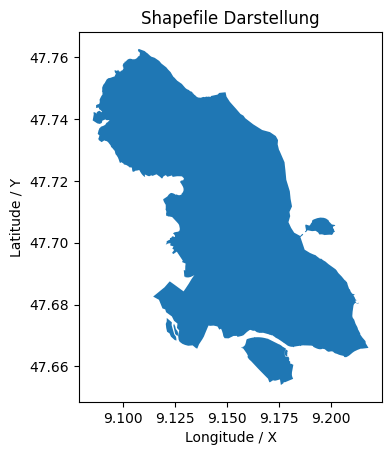

In [12]:
print(f"Koordinatensystem: EPSG({shapefile_epsg})")
print(f"Bounding Box: {shapefile_bounds}")

# Optional: Quick plot of your Shapefile
gdf.plot()
plt.title("Shapefile Darstellung")
plt.xlabel("Longitude / X")
plt.ylabel("Latitude / Y")
plt.show()

> Important: Generally, **kn_bounds_laea** is sufficient for extracting CSV and GeoTIFF, but adjustments may be needed because:
* **x** and **y** represent grid cell centers, and bounding box edges may not align perfectly with these centers.
* Without adjustment, grid cells near the edges might be excluded if bounding box edges fall between grid centers.
* Adjusting ensures all relevant grid cells are included.

<div style="display: flex; justify-content: center; gap: 10px;">
  <figure style="margin: 0;">
    <img src="./images/ppt_normal.png" width="400" style="border: 1px solid #aeaeae; display: block;">
    <figcaption style="text-align: center; margin-top: 5px;">Extent w/o bbox adjustment (kn_bounds_laea)</figcaption>
  </figure>
  <figure style="margin: 0;">
    <img src="./images/ppt_adjusted.png" width="400" style="border: 1px solid #aeaeae; display: block;">
    <figcaption style="text-align: center; margin-top: 5px;">Extent w/ bbox adjustment (kn_bounds_laea_adjusted)</figcaption>
  </figure>
</div>

It is recommended to use **kn_bounds_laea_adjusted** for extracting GeoTIFF files.

In [13]:
# Open the NetCDF file in read mode
nc_filepath = os.path.join(extract_folder, 'LAPrec1901.v1.2.nc')
nc_dataset = nc.Dataset(nc_filepath, mode='r')

# Define variable name from available variables and read variable data
variable_name = 'LAPrec1901'
variable_data = nc_dataset[variable_name]

x = nc_dataset['X'][:]
y = nc_dataset['Y'][:]

# Validate bounding box dimensions
dx = x[1] - x[0]  # X-axis resolution
dy = y[1] - y[0]  # Y-axis resolution

# Adjust the bounding box to align with grid edges
x_min_adjusted = max(x_min - dx / 2, x.min())
x_max_adjusted = min(x_max + dx / 2, x.max())
y_min_adjusted = max(y_min - dy / 2, y.min())
y_max_adjusted = min(y_max + dy / 2, y.max())

shapefile_bounds_laea_adjusted = [x_min_adjusted, y_min_adjusted, x_max_adjusted, y_max_adjusted]
print(shapefile_bounds_laea_adjusted)

[np.float64(4249754.817823338), np.float64(2724632.614227563), np.float64(4264844.998739288), np.float64(2741595.48723691)]


### 4.2 Filter Data by Bounding Box and Export as CSV

In [14]:
import xarray as xr

# Open the NetCDF dataset using xarray
with xr.open_dataset(nc_filepath) as nc_dataset:
    variable_data = nc_dataset[variable_name]
    
    # Generate the CSV file path
    csv_filename = f"{variable_name}_filtered_data.csv"
    csv_filepath = os.path.join(csv_folder, csv_filename)

    # Export the filtered data to a CSV file if it doesn't already exist
    if not os.path.isfile(csv_filepath):
        # Apply geographic filtering using the defined bounding box
        filtered_data = variable_data.where(
            (nc_dataset['X'] >= x_min_adjusted) & (nc_dataset['X'] <= x_max_adjusted) &
            (nc_dataset['Y'] >= y_min_adjusted) & (nc_dataset['Y'] <= y_max_adjusted),
            drop=True
        )

        # Convert the filtered data into a DataFrame
        filtered_df = filtered_data.to_dataframe().reset_index().set_index(['time', 'Y', 'X'])
        filtered_df.to_csv(csv_filepath, index=True)
        print(f"Filtered data exported successfully to {csv_filepath}")
    else:
        print(f"File already exists at {csv_filepath}. Skipping export.")
        print("Reading existing CSV file...")
        filtered_df = pd.read_csv(csv_filepath).reset_index().set_index(['time', 'Y', 'X'])

# Modify display format for numbers in the DataFrames
pd.options.display.float_format = '{:,.2f}'.format

# Display the filtered DataFrame
filtered_df

File already exists at .\data\alpine-monthly-precipitation\csv\LAPrec1901_filtered_data.csv. Skipping export.
Reading existing CSV file...


index  LAPrec1901
time       Y            X                              
1901-01-01 2,725,000.00 4,250,000.00      0       37.00
                        4,255,000.00      1       36.00
                        4,260,000.00      2       36.00
           2,730,000.00 4,250,000.00      3       37.00
                        4,255,000.00      4       33.00
...                                     ...         ...
2020-12-01 2,735,000.00 4,255,000.00  17275       57.00
                        4,260,000.00  17276       56.00
           2,740,000.00 4,250,000.00  17277       56.00
                        4,255,000.00  17278       57.00
                        4,260,000.00  17279       58.00

[17280 rows x 2 columns]

### 4.3 Compute Monthly Means and Export as CSV

In [15]:
# Generate the output file path
csv_filename_monthly_means = f"{variable_name}_monthly_means.csv"
csv_filepath_monthly_means = os.path.join(csv_folder, csv_filename_monthly_means)

# Export the pivot table to CSV if it doesn't already exist
if not os.path.isfile(csv_filepath_monthly_means):
    # Convert the 'time' column to datetime format
    filtered_df_copy = filtered_df.copy().reset_index()
    filtered_df_copy['time'] = pd.to_datetime(filtered_df_copy['time'])

    # Extract year and month from the 'time' column
    filtered_df_copy['Year'] = filtered_df_copy['time'].dt.year
    filtered_df_copy['Month'] = filtered_df_copy['time'].dt.month

    # Group by year and month, calculate the mean for the specified variable
    monthly_means = (
        filtered_df_copy.groupby(['Year', 'Month'])[variable_name]
        .mean()
        .reset_index()
        .round({variable_name: 2})
    )

    # Create a pivot table with years as rows and months as columns
    df_monthly_means = monthly_means.pivot(index='Year', columns='Month', values=variable_name)

    # Ensure all months (1–12) are included, and add yearly totals
    df_monthly_means = df_monthly_means.reindex(columns=range(1, 13))
    df_monthly_means[f"Yearly_Sum"] = df_monthly_means.sum(axis=1)
    df_monthly_means.to_csv(csv_filepath_monthly_means, index=True)
    print(f"Monthly mean data exported successfully to {csv_filepath}")
else:
    print(f"File already exists at {csv_filepath}. Skipping export.")
    print("Reading existing CSV file...")
    df_monthly_means = pd.read_csv(csv_filepath_monthly_means)

# Display the pivot table
df_monthly_means

File already exists at .\data\alpine-monthly-precipitation\csv\LAPrec1901_filtered_data.csv. Skipping export.
Reading existing CSV file...


,Year,1,2,3,4,5,6,7,8,9,10,11,12,Yearly_Sum
0,1901,31.17,26.00,65.42,124.58,16.50,129.33,84.33,88.00,88.08,36.17,25.33,44.50,759.41
1,1902,32.00,55.58,53.75,35.92,107.08,72.33,89.25,115.42,78.00,78.92,15.25,79.83,813.33
2,1903,35.00,27.83,37.00,53.17,39.83,88.50,131.33,100.67,45.00,76.00,81.08,16.58,731.99
3,1904,29.17,95.75,36.58,60.75,129.83,78.33,22.17,64.00,98.83,34.25,44.92,40.08,734.66
4,1905,44.08,24.33,84.17,83.67,75.58,64.33,76.42,178.92,117.50,101.50,47.33,37.58,935.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2016,144.00,90.67,32.08,100.50,154.08,153.42,97.17,62.58,48.75,48.25,70.08,1.42,"1,003.00"
116,2017,47.58,50.00,49.08,100.50,79.83,82.67,114.75,109.25,75.17,42.17,84.50,89.00,924.50
117,2018,108.92,41.92,44.33,13.25,84.83,62.08,44.75,69.17,64.75,38.25,13.08,94.92,680.25
118,2019,55.67,35.50,51.50,43.50,140.00,68.00,99.58,117.67,64.33,101.58,43.58,48.25,869.16


### 4.4 Plot Monthly Averages for a Defined Date Range

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_monthly_averages(start_year=None, end_year=None):
    """
    Plots the monthly averages of a variable with error bars for a given time range.

    Parameters:
        start_year (int): Starting year for the dataset (optional).
        end_year (int): Ending year for the dataset (optional).
    """
    # Read filtered dataframe from CSV file
    filtered_df = pd.read_csv(csv_filepath)
    filtered_df['time'] = pd.to_datetime(filtered_df['time'])
    
    # Adjust the start and end year to match available data
    if start_year and end_year:
        if start_year < min(filtered_df["time"].dt.year):
            print(f"Provided start year {start_year} is earlier than the dataset range. Adjusting start year to {min(filtered_df['time'].dt.year)}.")
            start_year = min(filtered_df["time"].dt.year)
        if end_year > max(filtered_df["time"].dt.year):
            print(f"Provided end year {end_year} is later than the dataset range. Adjusting end year to {max(filtered_df['time'].dt.year)}.")
            end_year = max(filtered_df["time"].dt.year)
    else:
        start_year=min(filtered_df["time"].dt.year)
        end_year=max(filtered_df["time"].dt.year)
        
    # Filter data for the defined period
    df_period = filtered_df[
        (filtered_df["time"].dt.year >= start_year)
        & (filtered_df["time"].dt.year <= end_year)
    ]

    # Calculate monthly statistics: mean and standard deviation
    monthly_stats = df_period.groupby(df_period['time'].dt.month)[variable_name].agg(['mean', 'std'])

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

    # Plot the bar diagram with error bars
    ax.bar(
        monthly_stats.index,
        monthly_stats['mean'],
        yerr=monthly_stats['std'],
        capsize=5,
        color='skyblue',
        alpha=0.7,
        error_kw=dict(ecolor='black', lw=0.75),
    )

    # Set the Y-axis range dynamically
    y_min = max(0, monthly_stats['mean'].min() - monthly_stats['std'].max() - 0.5)
    y_min = y_min // 20 * 20
    y_max = monthly_stats['mean'].max() + monthly_stats['std'].max() + 0.5
    y_max = (y_max + 20) // 20 * 20
    ax.set_ylim(y_min, y_max)

    # Add gridlines
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Customize plot labels and title
    ax.set_xlabel('Monat', fontsize=12)
    ax.set_ylabel('Durchschnittlicher Niederschlag (mm)', fontsize=12)
    ax.set_title(
        f'Durchschnittlicher Niederschlag pro Monat (Periode Jan {start_year} - Dez {end_year})',
        fontsize=14,
        fontweight='bold'
    )

    # Customize x-axis with month names
    month_labels = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels, rotation=0)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

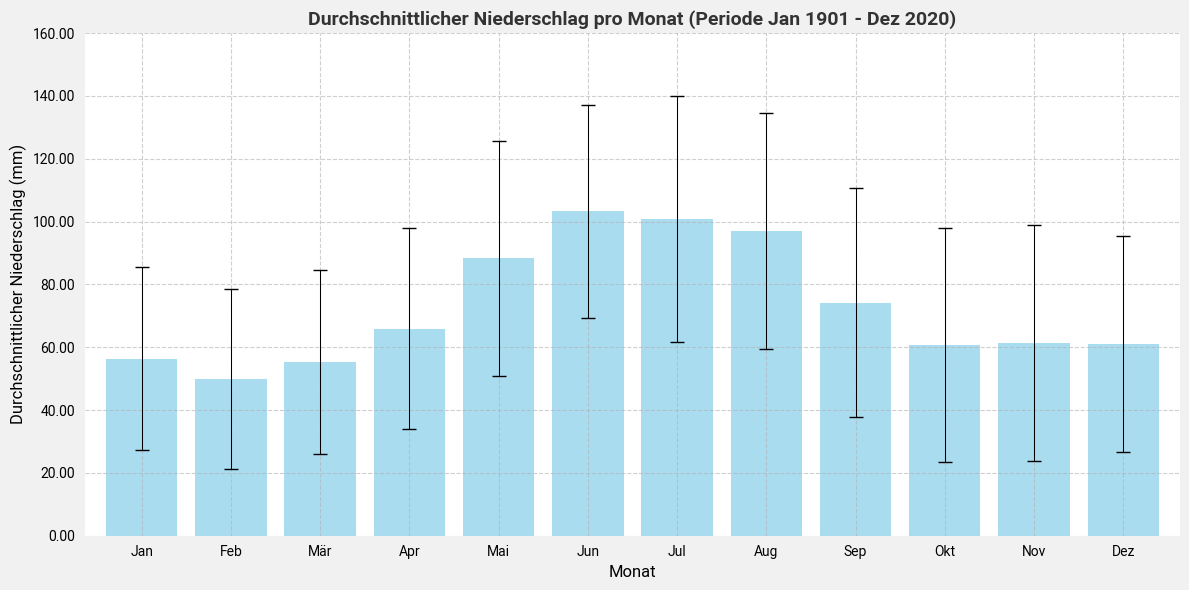

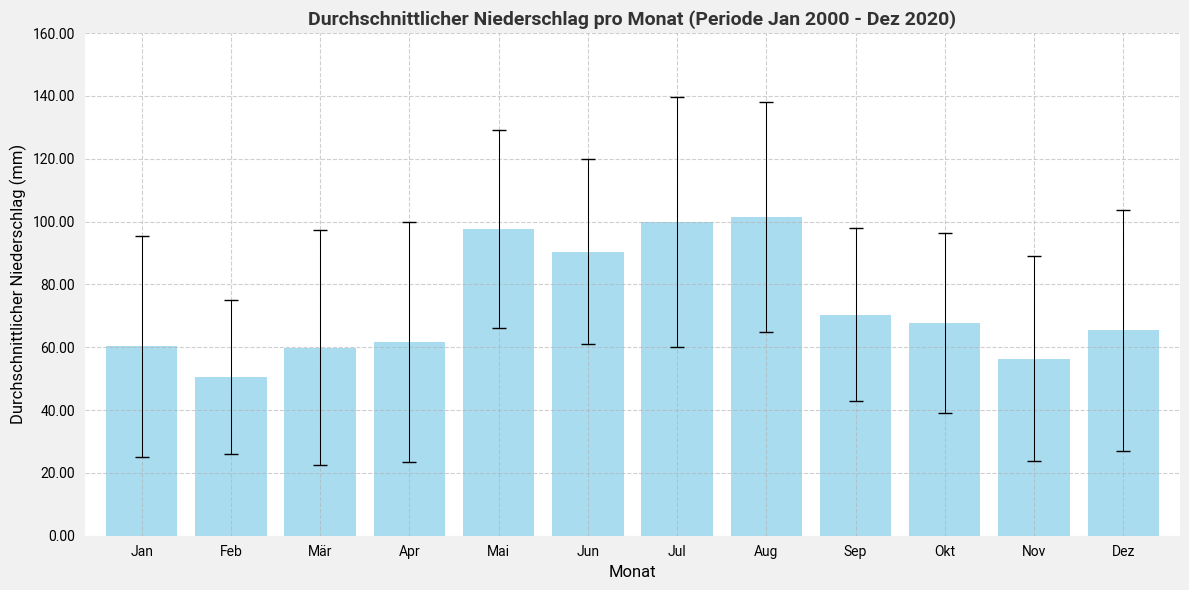

In [17]:
# Specify the year range to filter and plot monthly average.
# If no range is provided, complete dataset will be used.
if __name__ == "__main__":
    plot_monthly_averages() # Plot using complete dataset
    plot_monthly_averages(2000,2020) # Plot using specified year range

## 5. Export Dataset to GeoTIFF

### 5.1 Export All-Year Dataset as Individual GeoTIFF Files

In [18]:
import rasterio
from rasterio.transform import from_origin
import netCDF4 as nc
from tqdm.notebook import tqdm

def main_export_geotiff():
    # File paths and variable names
    nc_filepath = os.path.join(extract_folder, 'LAPrec1871.v1.2.nc')
    variable_name = 'LAPrec1871'

    # Open the NetCDF dataset and read variable data
    nc_dataset = nc.Dataset(nc_filepath, mode='r')
    precipitation_data = nc_dataset[variable_name]

    # Extract time variable and convert it to readable dates
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

    # Compute spatial resolution and raster transformation
    x = nc_dataset['X'][:]
    y = nc_dataset['Y'][:]
    dx = abs(x[1] - x[0])
    dy = abs(y[1] - y[0])
    transform = from_origin(x.min() - dx / 2, y.min() - dy / 2, dx, -dy)
    
    # Create folder for individual geotiffs
    output_folder = os.path.join(geotiff_folder, "individual_geotiff")
    os.makedirs(output_folder, exist_ok=True)

    if len(os.listdir(output_folder)) == 0:
        # Iterate over the time dimension to process each time slice
        for year_index in tqdm(range(precipitation_data.shape[0]), desc="Exporting individual GeoTIFF files"):
            # Retrieve the date for the current time slice
            dt = cftime[year_index]
            dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

            # Define the output GeoTIFF file path for individual GeoTIFFs
            output_filename = f"{variable_name}_{dt_full}.tif"
            output_filepath = os.path.join(output_folder, output_filename)

            # Export the current time slice as a GeoTIFF
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(precipitation_data.dtype),
                width = precipitation_data.shape[2],
                height = precipitation_data.shape[1],
                count = 1,
                crs = "EPSG:3035",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                year_precipitation_data = precipitation_data[year_index,:,:]
                dt = cftime[year_index]
                
                dst.write(year_precipitation_data, 1)
                dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

    else:
        print("Folder is not empty. Skipping export.")

    nc_dataset.close()
    
if __name__ == "__main__":
    main_export_geotiff()

Folder is not empty. Skipping export.


### 5.2 Export Dataset as a Single Merged GeoTIFF File

In [19]:
def main_export_merged_geotiff(start_year=None,
                               end_year=None):
    """
    Export the entire multi-year dataset or a specified range as a single merged GeoTIFF file.

    Parameters:
        start_year (int): Starting year for the dataset (optional).
        end_year (int): Ending year for the dataset (optional).
    """
    # File paths and variable names
    nc_filepath = os.path.join(extract_folder, 'LAPrec1871.v1.2.nc')
    variable_name = 'LAPrec1871'

    # Open the NetCDF dataset and read variable data
    nc_dataset = nc.Dataset(nc_filepath, mode='r')

    # Extract time variable and convert it to readable dates
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
    
    # Compute spatial resolution and raster transformation
    x = nc_dataset['X'][:]
    y = nc_dataset['Y'][:]
    dx = abs(x[1] - x[0])
    dy = abs(y[1] - y[0])
    transform = from_origin(x.min() - dx / 2, y.min() - dy / 2, dx, -dy)

    # Determine the time range
    min_year = cftime[0].year
    max_year = cftime[-1].year

    if start_year and end_year:
        # Adjust start_year and end_year based on the available cftime range
        if start_year < min_year:
            print(f"Provided start year {start_year} is earlier than the dataset range. Adjusting start year to {min_year}.")
        if end_year > max_year:
            print(f"Provided end year {end_year} is later than the dataset range. Adjusting end year to {max_year}.")
        start_year = max(start_year, min_year)
        end_year = min(end_year, max_year)

        dt_full_start = start_year
        dt_full_end = end_year
    else:
        # Default to the full dataset
        dt_full_start = min_year
        dt_full_end = max_year
        start_year = min_year
        end_year = max_year

    # Find indices corresponding to the specified year range
    start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
    end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 12 # Months
    
    # Extract precipitation data for the specified data (year) range
    precipitation_data = nc_dataset[variable_name]
    precipitation_data_subset = precipitation_data[start_index:end_index, :, :]
        
    # Create folder for merged geotiff
    output_filename = f"{variable_name}_merged_{dt_full_start}-{dt_full_end}.tif"
    output_folder = os.path.join(geotiff_folder, "merged_geotiff")
    os.makedirs(output_folder, exist_ok=True)
    output_filepath = os.path.join(output_folder, output_filename)
    
    if not os.path.isfile(output_filepath):
        # Retrieve the date for the current time slice
        with rasterio.open(
            output_filepath,
            "w",
            driver = "GTiff",
            dtype = str(precipitation_data_subset.dtype),
            width = precipitation_data_subset.shape[2],
            height = precipitation_data_subset.shape[1],
            count = precipitation_data_subset.shape[0],
            crs = "EPSG:3035",
            nodata = -9999,
            transform=transform,        
        ) as dst:
            for year_index in tqdm(range(precipitation_data_subset.shape[0]), desc=f"Exporting merged GeoTIFF file from {start_year} to {end_year}"):
                band_data = precipitation_data_subset[year_index,:,:]
                dt = cftime[start_index + year_index]
                band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                
                # Write each year slice as a band
                dst.write(band_data, year_index + 1)
                dst.set_band_description(year_index + 1, band_desc)
    else:
        print("Folder is not empty. Skipping export.")

# Specify the year range to filter and combine data into a single GeoTIFF.
# If no range is provided, the full dataset will be used.
if __name__ == "__main__":
    main_export_merged_geotiff() # Export all the available data set
    main_export_merged_geotiff(2000,2020) # Export dataset defined by date (year) range

Folder is not empty. Skipping export.
Folder is not empty. Skipping export.


### 5.3 Export Data for a Defined Date Range and Area

In [20]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_filtered_geotiff(
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None):
    """
    Export the entire multi-year dataset or a specified range as a single merged GeoTIFF file.

    Parameters:
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Starting year for the dataset (optional).
        end_year (int): Ending year for the dataset (optional).
        merged (bool): Whether to generate merged geotiff or individual geotiffs (optional).
    """
    # File paths and variable names
    nc_filepath = os.path.join(extract_folder, 'LAPrec1871.v1.2.nc')
    variable_name = 'LAPrec1871'

    # Open the NetCDF dataset
    nc_dataset = nc.Dataset(nc_filepath, mode='r')
    
    # Read x and y coordinate data
    x = nc_dataset['X'][:]
    y = nc_dataset['Y'][:]

    # Apply geographic filtering using the defined bounding box
    if bounding_box:
        indices_x = np.where((x >= bounding_box[0]) & (x <= bounding_box[2]))[0]
        indices_y = np.where((y >= bounding_box[1]) & (y <= bounding_box[3]))[0]
        start_x, end_x = indices_x[0], indices_x[-1] + 1
        start_y, end_y = indices_y[0], indices_y[-1] + 1
    else:
        start_x, end_x = 0, len(x)
        start_y, end_y = 0, len(y)
    
    x = x[start_x:end_x]
    y = y[start_y:end_y]

    # Extract time variable and convert it to readable dates
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
    
    # Compute spatial resolution and raster transformation
    dx = abs(x[1] - x[0])
    dy = abs(y[1] - y[0])
    transform = from_origin(x.min() - dx / 2, y.min() - dy / 2, dx, -dy)

    # Determine the time range
    min_year = cftime[0].year
    max_year = cftime[-1].year

    if start_year and end_year:
        # Adjust start_year and end_year based on the available cftime range
        if start_year < min_year:
            print(f"Provided start year {start_year} is earlier than the dataset range. Adjusting start year to {min_year}.")
        if end_year > max_year:
            print(f"Provided end year {end_year} is later than the dataset range. Adjusting end year to {max_year}.")
        start_year = max(start_year, min_year)
        end_year = min(end_year, max_year)

        dt_full_start = start_year
        dt_full_end = end_year
    else:
        # Default to the full dataset
        dt_full_start = min_year
        dt_full_end = max_year
        start_year = min_year
        end_year = max_year

    # Find indices corresponding to the specified year range
    start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
    end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 12 # Months
     
    # Extract precipitation data for the specified data (year) range
    precipitation_data = nc_dataset[variable_name]
    precipitation_data_subset = precipitation_data[start_index:end_index,
                                                   start_y:end_y,
                                                   start_x:end_x]
    
    if merged:
        # Create a merged GeoTIFF containing all time slices as separate bands
        output_filename = f"{variable_name}_merged_{dt_full_start}-{dt_full_end}.tif"
        output_folder = os.path.join(geotiff_folder, "filtered_and_merged_geotiff")
        os.makedirs(output_folder, exist_ok=True)
        output_filepath = os.path.join(output_folder, output_filename)
        
        # Create a GeoTIFF with multiple bands for each time slice
        with rasterio.open(
            output_filepath,
            "w",
            driver = "GTiff",
            dtype = str(precipitation_data_subset.dtype),
            width = precipitation_data_subset.shape[2],
            height = precipitation_data_subset.shape[1],
            count = precipitation_data_subset.shape[0],
            crs = "EPSG:3035",
            nodata = -9999,
            transform=transform,        
        ) as dst:
            for year_index in tqdm(range(precipitation_data_subset.shape[0]), desc=f"Exporting merged GeoTIFF file from {start_year} to {end_year}"):
                band_data = precipitation_data_subset[year_index,:,:]
                dt = cftime[start_index + year_index]
                band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                
                # Write each year slice as a band
                dst.write(band_data, year_index + 1)
                dst.set_band_description(year_index + 1, band_desc)
    else:
        # Create individual GeoTIFFs for each time slice
        output_folder = os.path.join(geotiff_folder, "filtered_and_individual_geotiff")
        os.makedirs(output_folder, exist_ok=True)

        for year_index in tqdm(range(precipitation_data_subset.shape[0]), desc="Exporting individual GeoTIFF files"):
            # Retrieve the date for the current time slice
            dt = cftime[start_index + year_index]
            dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

            # Define the output GeoTIFF file path
            output_filename = f"{variable_name}_{dt_full}.tif"
            output_filepath = os.path.join(output_folder, output_filename)

            # Export the current time slice as a GeoTIFF
            with rasterio.open(
                output_filepath,
                "w",
                driver="GTiff",
                dtype=str(precipitation_data_subset.dtype),
                width=precipitation_data_subset.shape[2],
                height=precipitation_data_subset.shape[1],
                count=1,
                crs="EPSG:3035",
                nodata=-9999,
                transform=transform,
            ) as dst:
                year_precipitation_data = precipitation_data_subset[year_index, :, :]
                dst.write(year_precipitation_data, 1)
                dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

## 6. Plot using Matplotlib

### 6.1 Plot the Complete data

Plot saved to: .\data\alpine-monthly-precipitation\output\temp_images_folder\2020-08.png


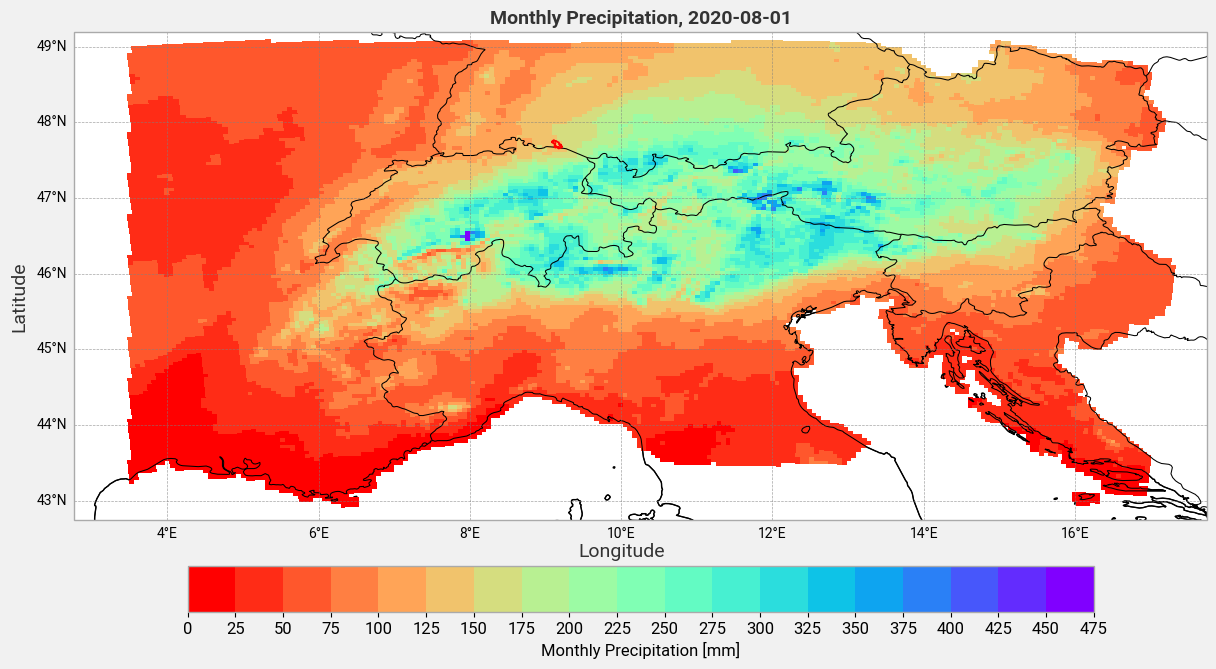

In [21]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd

def main_plt_plot(selected_year,
                  selected_month,
                  save):
    
    """
    Plots monthly precipitation data for a given year and month.

    Parameters:
        selected_year (str): The year to plot (e.g., '2020').
        selected_month (str): The month to plot (e.g., '08').
        save (bool): Whether to save the plot as a PNG file.
    """
    
    # File paths and variable names
    nc_filepath = os.path.join(extract_folder, 'LAPrec1871.v1.2.nc')
    variable_name = 'LAPrec1871'
    
    # Open the NetCDF dataset
    nc_dataset = nc.Dataset(nc_filepath, mode='r')
    lon = nc_dataset['lon'][:]
    lat = nc_dataset['lat'][:]

    # Extract time variable and convert it to readable dates
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

    # Extract data for selected date
    selected_date = f"{selected_year}-{selected_month}-01"
    target_index = np.where([t.strftime('%Y-%m-%d') == selected_date for t in cftime])[0][0]
    index_data = nc_dataset[variable_name][target_index, :, :]
    
    # Calculate vmin, vmax, and bins
    vmin = np.floor(np.nanmin(index_data) / 25) * 25
    vmax = np.ceil(np.nanmax(index_data) / 25) * 25
    interval = 25
    bins = int((vmax - vmin) / interval)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8),
                           facecolor='#f1f1f1',
                           edgecolor='k',
                           subplot_kw={'projection': ccrs.PlateCarree()})

    cmap = plt.get_cmap("rainbow_r", bins)
    pcm = ax.pcolormesh(lon,
                        lat,
                        index_data,
                        cmap=cmap,
                        shading="auto",
                        vmin=vmin,
                        vmax=vmax)

    # Add Shapefile
    konstanz_shp = r".\shapefiles\kn_boundary.shp"
    konstanz_boundary = gpd.read_file(konstanz_shp)
    konstanz_boundary = konstanz_boundary.to_crs(4326)
    konstanz_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=1.2)

    # Add a colorbar
    ticks = np.linspace(vmin, vmax, num=bins + 1)
    cbar = plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.06, shrink=0.8, ticks=ticks)
    cbar.set_label("Monthly Precipitation [mm]", fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    # # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.75, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.75)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    # ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')

    # Add grid lines
    gl = ax.gridlines(draw_labels=True,
                      crs=ccrs.PlateCarree(),
                      linewidth=0.5,
                      color='gray',
                      alpha=0.7,
                      linestyle='--')
    gl.top_labels = False 
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    # Add title and labels
    fig.text(0.5, 0.175, 'Longitude', ha='center', fontsize=14)
    fig.text(-0.01, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=14)
    ax.set_title(f"Monthly Precipitation, {selected_date}", fontsize=14, fontweight='bold')
    ax.set_aspect("equal")

    # Save or display the plot
    plt.tight_layout()
    if save:
        temp_images_folder = os.path.join(output_folder, "temp_images_folder")
        os.makedirs(temp_images_folder, exist_ok=True)
        image_filepath = os.path.join(temp_images_folder, f"{selected_year}-{selected_month}.png")
        plt.savefig(image_filepath, format='png', bbox_inches='tight')
        print(f"Plot saved to: {image_filepath}")
    plt.show()

if __name__ == "__main__":
    # Example usage
    main_plt_plot(
        selected_year='2020',
        selected_month='08',
        save=True,
    )

### 6.2 Plot monthly mean heatmap

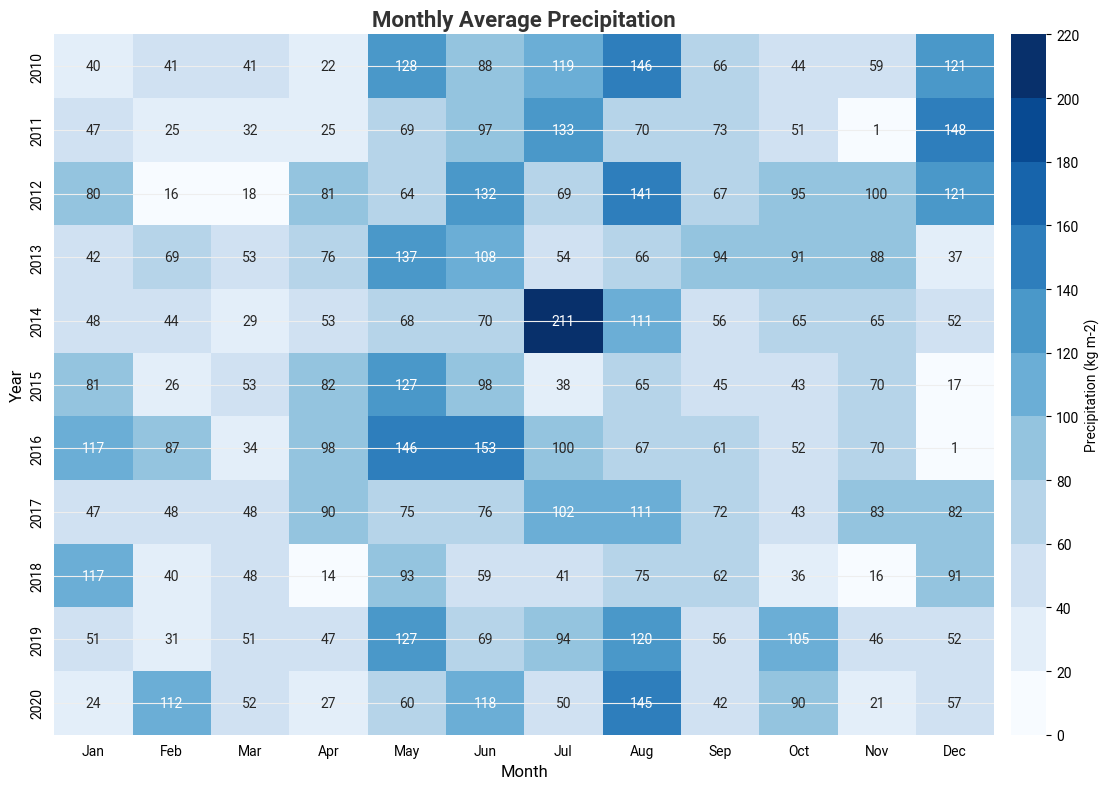

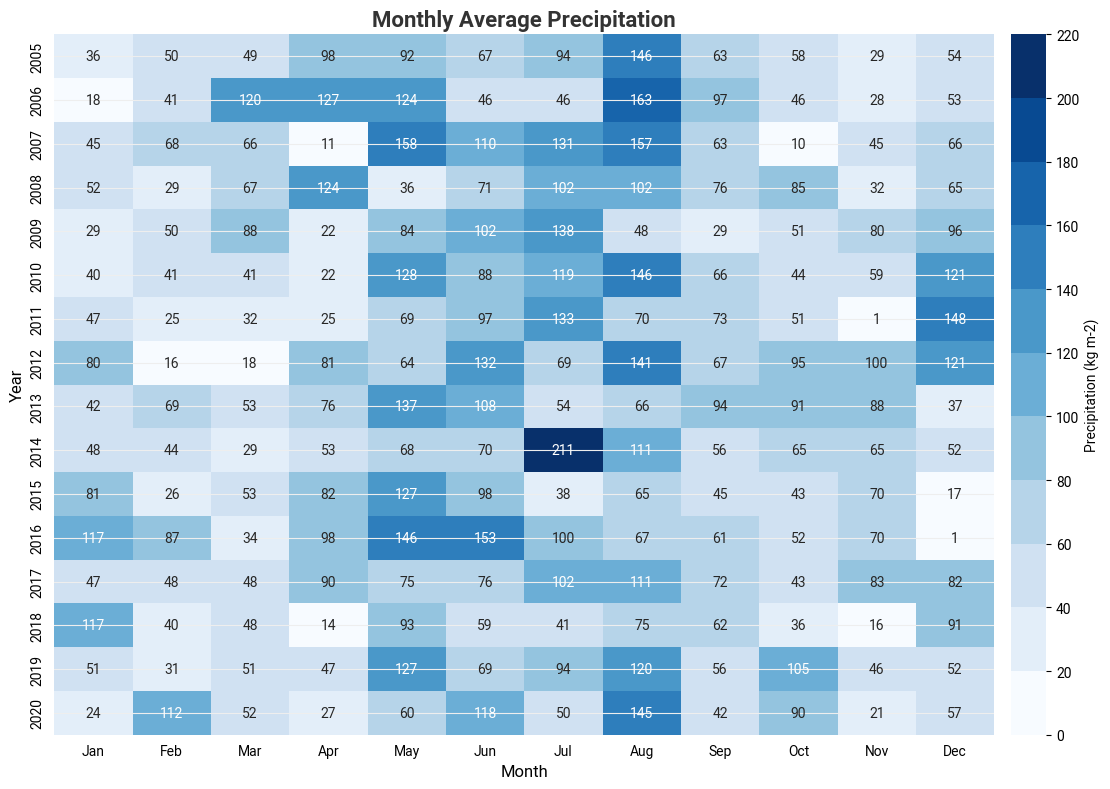

In [22]:
import seaborn as sns

def plot_precipitation_heatmap(start_year=2010,
                               end_year=None):
    """
    Creates a heatmap of monthly average precipitation from a CSV file.

    Parameters:
        start_year (int, optional): The starting year to filter the data. Default is 2010.
        end_year (int, optional): The ending year to filter the data. If not provided, filters up to the maximum year.
    """
    
    # Load data and preprocess
    csv_path = os.path.join(csv_folder, 'LAPrec1871_monthly_means.csv')
    df = pd.read_csv(csv_path)
    df = df.drop(columns=['Yearly_Sum'])
    df = df.set_index('Year')
    
    # Determine the effective end year
    max_year_in_data = df.index.max()
    if end_year is not None:
        end_year = min(max_year_in_data, end_year)
    else:
        end_year = max_year_in_data
    
    # Filter data based on start and end year
    df_filtered = df.loc[start_year:end_year]
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = plt.get_cmap('Blues', 11)
    
    sns.heatmap(
        df_filtered,
        cmap=cmap,
        annot=True,
        annot_kws={"fontsize": 10},
        fmt=".0f",
        cbar_kws={
            "label": f"Precipitation ({summary.get('Units', 'mm')})",
            "ticks": range(0, 221, 20),
            "pad": 0.015,
        },
        vmin=0,
        vmax=220
    )
    
    # Customize x-axis with month names
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']  
    ticks = range(1, 13)
    shifted_ticks = [tick - 0.5 for tick in ticks]
    # Set the ticks and labels
    ax.set_xticks(shifted_ticks)
    ax.set_xticklabels(month_labels, rotation=0, fontsize=10)
    
    # Add labels and title
    ax.set_title("Monthly Average Precipitation", fontsize=16, fontweight='bold')
    ax.set_xlabel("Month", fontsize=12)
    ax.set_ylabel("Year", fontsize=12)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
# Example usage
if __name__ == "__main__":
    plot_precipitation_heatmap(
        start_year=2010,
        end_year=2020
    )
    
    plot_precipitation_heatmap(
        start_year=2005,
    )